In [1]:
import tarfile
import pandas as pd
import numpy as np

import string, re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk import pos_tag

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score

# Read data from compressed file

In [2]:
f = tarfile.open("review_polarity.tar.gz", "r")
train_pos_file_list = []
train_neg_file_list = []
test_pos_file_list = []
test_neg_file_list = []
for member in f.getmembers():
    file=f.extractfile(member)
    content=file.read()
    if 'pos' in member.get_info()['name']:
        if 'cv9' in member.get_info()['name']:
            test_pos_file_list.append(content)
        else:
            train_pos_file_list.append(content)
    else:
        if 'cv9' in member.get_info()['name']:
            test_neg_file_list.append(content)
        else:
            train_neg_file_list.append(content)
    #sys.exit()
f.close()

# Data processing

In [3]:
train_pos_labels = [1 for i in range(len(train_pos_file_list))]
train_neg_labels = [0 for i in range(len(train_neg_file_list))]

test_pos_labels = [1 for i in range(len(test_pos_file_list))]
test_neg_labels = [0 for i in range(len(test_neg_file_list))]

In [4]:
train_labels = train_pos_labels + train_neg_labels
test_labels = test_pos_labels + test_neg_labels

In [5]:
train_pos_file_list = [str(text).replace("b'", "").replace("\\n","").replace("\\'","'") for text in train_pos_file_list]
train_neg_file_list = [str(text).replace("b'", "").replace("\\n","").replace("\\'","'") for text in train_neg_file_list]
test_pos_file_list = [str(text).replace("b'", "").replace("\\n","").replace("\\'","'") for text in test_pos_file_list]
test_neg_file_list = [str(text).replace("b'", "").replace("\\n","").replace("\\'","'") for text in test_neg_file_list]

In [6]:
train_file_list = train_pos_file_list + train_neg_file_list
test_file_list = test_pos_file_list + test_neg_file_list

# Function for model building

In [88]:
def show_most_informative_features(vectorizer, classifier, n=10):
    lines = []
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()  
    topn_pos_class = sorted(zip(classifier.feature_log_prob_[1], feature_names),reverse=True)[:n]
    topn_neg_class = sorted(zip(classifier.feature_log_prob_[0], feature_names),reverse=True)[:n]    

    print("Important words in positive reviews")
    for coef, feature in topn_pos_class:
        lines.append([class_labels[1], coef, feature])
        print(class_labels[1], coef, feature) 
    print("-----------------------------------------")
    print("Important words in negative reviews")
    for coef, feature in topn_neg_class:
        lines.append([class_labels[0], coef, feature])
        print(class_labels[0], coef, feature)
    return lines

In [45]:
def Get_Accuracy(whichcleaning, binary=False, ngram=False, tfidf=False, show=True, stem=False):
    files_train = [whichcleaning(word_tokenize(x), stem) for x in train_file_list]
    files_test = [whichcleaning(word_tokenize(x), stem) for x in test_file_list]

    if binary:
        vectorizer = CountVectorizer(binary=True)
    elif ngram:
        vectorizer = CountVectorizer(ngram_range=(2,2))
    elif tfidf:
        vectorizer = TfidfVectorizer(min_df = 5, stop_words='english', sublinear_tf=True, max_df = round(len(train_file_list) * .8))
    else:
        vectorizer = CountVectorizer()

    train_features = vectorizer.fit_transform([doc for doc in files_train])
    test_features = vectorizer.transform([doc for doc in files_test])

    tokens = vectorizer.get_feature_names()

    nb_clf = MultinomialNB()

    nb_clf.fit(train_features, train_labels)
    predictions = nb_clf.predict(test_features)

    accuracy = accuracy_score(predictions, test_labels)
    print("Accuracy is {}%".format(accuracy*100))
    
    if show:
        # print out most informative features
        thing = show_most_informative_features(vectorizer, nb_clf, n=5)
        return accuracy, thing
    else:
        return accuracy

# 1.	Problem 1. 
In building the baselines, what shallow text features make sense for the task as a first-stab approach? (e.g., a language modeling approach is a standard way to tackle this problem, i.e., a bag-of-words approach). Experiment with the following baseline models (note that you have to run a POS tagger for models M3):

- Run the classifier for each baseline feature and report the performance. What is the best model and which model is the least performant? 

- How do you interpret the differences in performance across these models (i.e., why do you think one model is better than another)? 

- For the unigram models M1-M4, list the top 5 most informative words identified by the classifier. What do you notice here? (compare these lists).

## -M1: word present/absent

In [10]:
# word present/absent
def clean(tokenized, stem=False):
    punctuation_free = [x for x in tokenized if not re.fullmatch('[' + string.punctuation + ']+', x)]
    unique_punctuation_free = list(set(punctuation_free))
    if stem:
        stemmedWords = []
        for word in unique_punctuation_free:
            try:
                a = stemmer.stem(word)
                stemmedWords.append(a)
            except:
                next
        return ' '.join(stemmedWords)
    else:
        return ' '.join(unique_punctuation_free)

In [11]:
# # create a dataframe from a word matrix
def wm2df(wm, feat_names):
    # create an index for each row
    doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(), index=doc_names,
                   columns=feat_names)
    return(df)

In [21]:
accuracy_wp, imp_wp = Get_Accuracy(whichcleaning=clean, binary=True)

Accuracy is 86.0%
Important words in positive reviews
1 -5.956848974266556 the
1 -5.956848974266556 of
1 -5.957959468550583 to
1 -5.957959468550583 is
1 -5.957959468550583 and
-----------------------------------------
Important words in negative reviews
0 -5.889864371418765 the
0 -5.889864371418765 of
0 -5.889864371418765 and
0 -5.890974865702792 to
0 -5.890974865702792 is


In [63]:
with open('answers.txt', 'w+') as f:
    f.writelines("\nProblem 1: M1 Word absence & presence\n")
    f.writelines("Accuracy is {}%\n".format(accuracy_wp))
    for line in imp_wp:
        f.writelines("{} {} {}\n".format(line[0], line[1], line[2]))
    f.writelines("The accuracy is quite high. However, the most informative words are almost exactly the same for both classes. These words seems to be stop words, that are common is any documents.\n")

> The accuracy is quite high. However, the most informative words are almost exactly the same for both classes. These words seems to be stop words, that are common is any documents.

## - M2: term frequency

In [31]:
# term frequency
def clean1(tokenized, stem=False):
    punctuation_free = [x for x in tokenized if not re.fullmatch('[' + string.punctuation + ']+', x)]
    if stem:
        stemmedWords = []
        for word in punctuation_free:
            try:
                a = stemmer.stem(word)
                stemmedWords.append(a)
            except:
                next
        return ' '.join(stemmedWords)
    else:
        return ' '.join(punctuation_free)

In [32]:
accuracy_tf, imp_tf = Get_Accuracy(whichcleaning=clean1)

Accuracy is 83.5%
Important words in positive reviews
1 -2.840738587277439 the
1 -3.5756175119023332 and
1 -3.6397703179736975 of
1 -3.759997481071675 to
1 -3.898152823893758 is
-----------------------------------------
Important words in negative reviews
0 -2.899320163163642 the
0 -3.7056424046697813 and
0 -3.719386357592498 of
0 -3.7196026127744553 to
0 -4.0058678632326075 is


In [64]:
with open('answers.txt', 'a') as f:
    f.writelines("\nProblem 1: M2 Term frequency\n")
    f.writelines("Accuracy is {}%\n".format(accuracy_tf))
    for line in imp_tf:
        f.writelines("{} {} {}\n".format(line[0], line[1], line[2]))
    f.writelines("The accuracy is also quite high. However, once again, the most informative words are almost exactly the same for both classes. These words seems to be stop words, that are common is any documents.\n")

> The accuracy is also quite high. However, once again, the most informative words are almost exactly the same for both classes. These words seems to be stop words, that are common is any documents.

## - M3: POS advj

In [34]:
def clean_pos(tokenized, stem=False):
    punctuation_free = [x for x in tokenized if not re.fullmatch('[' + string.punctuation + ']+', x)]
    word_posTags = pos_tag(punctuation_free)
    # get adjv words by the POS tags
    adjv_words = [x[0] for x in word_posTags if len(re.findall('(RB\w*|JJ\w*)', x[1]))>0]
    # presence/absence
    unique_adjv_words = list(set(adjv_words))
    if stem:
        stemmedWords = []
        for word in unique_adjv_words:
            try:
                a = stemmer.stem(word)
                stemmedWords.append(a)
            except:
                next
        return ' '.join(stemmedWords)
    else:
        return ' '.join(unique_adjv_words)

In [35]:
accuracy_pos, imp_pos = Get_Accuracy(whichcleaning=clean_pos, binary=True)

Accuracy is 87.0%
Important words in positive reviews
1 -4.839375545880551 not
1 -4.978294782472198 more
1 -5.005486790167449 when
1 -5.065441651637363 so
1 -5.122313162591969 most
-----------------------------------------
Important words in negative reviews
0 -4.784832166746287 not
0 -4.916657559525709 when
0 -4.930387752337611 so
0 -4.930387752337611 more
0 -4.979177916507043 only


In [65]:
with open('answers.txt', 'a') as f:
    f.writelines("\nProblem 1: M3 Adj/Adv POS tagging\n")
    f.writelines("Accuracy is {}%\n".format(accuracy_pos))
    for line in imp_pos:
        f.writelines("{} {} {}\n".format(line[0], line[1], line[2]))
    f.writelines("The accuracy is the highest so far. However, once again, the most informative words are almost exactly the same for both classes. These words seems to be stop words, that are common is any documents.\n")

> The accuracy is the highest so far. However, once again, the most informative words are almost exactly the same for both classes. These words seems to be stop words, that are common is any documents.

## -M4: Sublinear tf-idf
Note: For model M4 use sublinear tf-idf. Here, besides removing stop words, you also have to remove those vocabulary words that occurred in less than 5 documents (i.e., files) and those that occurred in more than 80% of documents.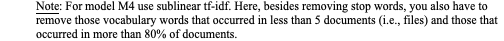

In [40]:
stop_words = set(stopwords.words('english'))

In [38]:
def clean_tfidf(tokenized, stem=False):
    cleaned = [x for x in tokenized if not re.fullmatch('[' + string.punctuation + ']+', x) and x not in stop_words]
    if stem:
        stemmedWords = []
        for word in cleaned:
            try:
                a = stemmer.stem(word)
                stemmedWords.append(a)
            except:
                next
        return ' '.join(stemmedWords)
    else:
        return ' '.join(cleaned)

In [41]:
accuracy_tfidf, imp_tfidf = Get_Accuracy(whichcleaning=clean_tfidf, tfidf=True)

Accuracy is 85.5%
Important words in positive reviews
1 -6.950690881656748 movie
1 -7.117846360899243 like
1 -7.217263992577482 story
1 -7.219986250430932 life
1 -7.229668354616171 good
-----------------------------------------
Important words in negative reviews
0 -6.738589295181579 movie
0 -6.97872693412327 like
0 -7.098268371686496 bad
0 -7.183224842908503 good
0 -7.211225327985219 plot


/opt/anaconda3/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [66]:
with open('answers.txt', 'a') as f:
    f.writelines("\nProblem 1: M4 Sublinear TF-IDF\n")
    f.writelines("Accuracy is {}%\n".format(accuracy_tfidf))
    for line in imp_tfidf:
        f.writelines("{} {} {}\n".format(line[0], line[1], line[2]))
    f.writelines("The accuracy is also quite high. However, once again, the most informative words are almost exactly the same for both classes, even when the stop words are removed. The only noticeable difference is that the negative word 'bad' is only most informative for the negative class.\n")

> The accuracy is also quite high. However, once again, the most informative words are almost exactly the same for both classes, even when the stop words are removed. The only noticeable difference is that the negative word 'bad' is only most informative for the negative class.

## -M5: Bigrams

In [46]:
accuracy_bg = Get_Accuracy(clean1, ngram=True, show=False)

Accuracy is 83.5%


In [67]:
with open('answers.txt', 'a') as f:
    f.writelines("\nProblem 1: M5 Bigrams\n")
    f.writelines("Accuracy is {}%\n".format(accuracy_bg))
    f.writelines("Bigram accuracy is the lowest among all. Seems like neigbouring words do not help the classifier to identify classes.\n")

> Bigram accuracy is the lowest among all. Seems like neigbouring words do not help the classifier to identify classes.

# Problem 2. 
Redo Problem1 but with stemming (use Porter’s stemmer). Is this worth doing? Compare the models’ performance with those at Problem1.

In [50]:
from nltk.stem import PorterStemmer

In [51]:
stemmer = PorterStemmer()

## - M1

In [52]:
acc_p2m1, imp_p2m1 = Get_Accuracy(whichcleaning=clean, binary=True, stem=True)

Accuracy is 86.5%
Important words in positive reviews
1 -5.874126057465444 the
1 -5.874126057465444 of
1 -5.875236551749471 to
1 -5.875236551749471 is
1 -5.875236551749471 and
-----------------------------------------
Important words in negative reviews
0 -5.811011388055521 the
0 -5.811011388055521 of
0 -5.811011388055521 and
0 -5.8121218823395475 to
0 -5.8121218823395475 is


In [68]:
with open('answers.txt', 'a') as f:
    f.writelines("\nProblem 2: M1\n")
    f.writelines("Accuracy is {}%\n".format(acc_p2m1))
    for line in imp_p2m1:
        f.writelines("{} {} {}\n".format(line[0], line[1], line[2]))

## - M2

In [54]:
acc_p2m2, imp_p2m2 = Get_Accuracy(whichcleaning=clean1, stem=True)

Accuracy is 83.5%
Important words in positive reviews
1 -2.8218423300926645 the
1 -3.5565865292205547 and
1 -3.6204997425983514 of
1 -3.7408313906412616 to
1 -3.879199411704203 is
-----------------------------------------
Important words in negative reviews
0 -2.878436116876138 the
0 -3.6844726304885285 and
0 -3.6981445087418567 of
0 -3.6984328385932024 to
0 -3.984986093661419 is


In [69]:
with open('answers.txt', 'a') as f:
    f.writelines("\nProblem 2: M2\n")
    f.writelines("Accuracy is {}%\n".format(acc_p2m2))
    for line in imp_p2m2:
        f.writelines("{} {} {}\n".format(line[0], line[1], line[2]))

## -M3

In [56]:
acc_p2m3, imp_p2m3 = Get_Accuracy(whichcleaning=clean_pos, binary=True, stem=True)

Accuracy is 86.5%
Important words in positive reviews
1 -4.816078359324657 not
1 -4.954997595916304 more
1 -4.982189603611555 when
1 -5.042144465081469 so
1 -5.099015976036076 most
-----------------------------------------
Important words in negative reviews
0 -4.7584993363994705 not
0 -4.892977250628024 when
0 -4.9067074434399265 so
0 -4.9067074434399265 more
0 -4.955497607609358 onli


In [70]:
with open('answers.txt', 'a') as f:
    f.writelines("\nProblem 2: M3\n")
    f.writelines("Accuracy is {}%\n".format(acc_p2m3))
    for line in imp_p2m3:
        f.writelines("{} {} {}\n".format(line[0], line[1], line[2]))

## -M4

In [59]:
acc_p2m4, imp_p2m4 = Get_Accuracy(whichcleaning=clean_tfidf, tfidf=True, stem=True)

Accuracy is 85.0%
Important words in positive reviews
1 -6.851678248100096 charact
1 -6.873881312329068 like
1 -6.913031948970374 make
1 -6.93374621915882 time
1 -6.975088959919418 stori
-----------------------------------------
Important words in negative reviews
0 -6.725568462109111 like
0 -6.811139260741474 charact
0 -6.881642269038005 bad
0 -6.890574116575978 make
0 -6.939384912776044 time


/opt/anaconda3/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [71]:
with open('answers.txt', 'a') as f:
    f.writelines("\nProblem 2: M4\n")
    f.writelines("Accuracy is {}%\n".format(acc_p2m4))
    for line in imp_p2m4:
        f.writelines("{} {} {}\n".format(line[0], line[1], line[2]))

## -M5

In [61]:
acc_p2m5 = Get_Accuracy(clean1, ngram=True, show=False, stem=True)

Accuracy is 83.5%


In [72]:
with open('answers.txt', 'a') as f:
    f.writelines("\nProblem 2: M5\n")
    f.writelines("Accuracy is {}%\n".format(acc_p2m5))
    f.writelines("The accuracy did not significantly increase and sometimes decreased so it is not worth stemming.\n")

> The accuracy did not significantly increase and sometimes decreased so it is not worth stemming.

# Problem 3. 
Here you have to experiment with the Pos/Neg ratio (use the EmoLex lexicon provided). Compare the performance of this model with those you got for Problems 1 and 2.

In [73]:
emolex = []
with open("NRC_Emotion.txt", "r") as f:
    emolex.append(f.readlines())

In [74]:
emolex = [x.replace("\n","").split("\t") for x in emolex[0]]

In [75]:
emolex_df = pd.DataFrame(emolex).rename(columns=dict(zip(range(4), ["word",'area','pos_neg','none'])))

In [76]:
# only take the mode for words with multiple sentiments
pos_neg = emolex_df.groupby("word").pos_neg.apply(lambda x: x.mode().mean()).reset_index()

In [77]:
pos_neg_dic = dict(zip(pos_neg.word, pos_neg.pos_neg))

In [78]:
def sentiment_score(tokenized):
    pos = 0
    neg = 0
    for word in tokenized:
        try:
            score = pos_neg_dic[word]
            if score == 1:
                neg += 1
            elif score == 0:
                pos += 1
        except:
            next
    if neg == 0 and pos == 0:
        return 0
    elif neg == 0:
        return pos
    else:
        return pos/neg

In [79]:
scores_train = [sentiment_score(word_tokenize(x)) for x in train_file_list]

In [80]:
scores = [sentiment_score(word_tokenize(x)) for x in test_file_list]

In [83]:
nb_clf = MultinomialNB()

nb_clf.fit(np.reshape(scores_train, (len(scores_train), 1)), train_labels)

predictions = nb_clf.predict(np.reshape(scores, (len(scores), 1)))

accuracy = accuracy_score(predictions, test_labels)
print("Accuracy is {}%".format(accuracy*100))

Accuracy is 50.0%


In [84]:
with open('answers.txt', 'a') as f:
    f.writelines("\nProblem 3: Pos/Neg Ratio\n")
    f.writelines("Accuracy is {}%\n".format(accuracy))

# Problem 4. 
How would you improve over the models you have experimented with so far? Meaning, what text features are most beneficial to the task of sentiment analysis? -- i.e., if you had to do it again, what would you change? For example, if you had to solve the problem in a different (and hopefully more efficient way), which features would you choose? Write 1-2 short paragraphs about the features you might want to try for this problem.

In [ ]:
# numbers to placeholders
# get rid of stopwords / movie related words
# only keeping the words that are not neutral

> Based on the previous exercise, it seems like it would be beneficial to do the following things:
    1. Numbers can be converted to just placeholders. There are many numbers that became parts of the dictionary. However, the different numbers do not have different sentiments attached unless they are used as ways to rate things.
    2. Removing stop words and words that are generic for the subject (e.g. movie, story, plot). As is seen previously, removing stop words helped with model performance. We can go one step further to remove generic words that refers to the subject in discussion. Previously, the informative words were things like movie, story, and plot. However, they are just words that are synonyms to the subject "movie". Thus getting rid of them might make the more sentiment-telling words surface more easily.
    3. Only keeping words that are not neutral (i.e. sentiment-telling words). Even though the pos/neg ratio did not work too well with predicting sentiment, one thing that it can be useful is as a filter. After only keeping the non-neutral words, if will be more clear what the sentiment of the text is.

In [86]:
with open('answers.txt', 'a') as f:
    f.writelines("\nProblem 4: Improvements\n")
    f.writelines("1. Numbers can be converted to just placeholders. There are many numbers that became parts of the dictionary. However, the different numbers do not have different sentiments attached unless they are used as ways to rate things.\n")
    f.writelines("2. Removing stop words and words that are generic for the subject (e.g. movie, story, plot). As is seen previously, removing stop words helped with model performance. We can go one step further to remove generic words that refers to the subject in discussion. Previously, the informative words were things like movie, story, and plot. However, they are just words that are synonyms to the subject 'movie'. Thus getting rid of them might make the more sentiment-telling words surface more easily.\n")
    f.writelines("3. Only keeping words that are not neutral (i.e. sentiment-telling words). Even though the pos/neg ratio did not work too well with predicting sentiment, one thing that it can be useful is as a filter. After only keeping the non-neutral words, if will be more clear what the sentiment of the text is.\n")